In [4]:
#Ratio of fixation time on keyboard VS average CPS (per sentence)

import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats


In [5]:
def readPickle(filename):
    import pickle

    # reload a file to a variable
    with open(filename, 'rb') as file:
        a_dict1 =pickle.load(file)

    return a_dict1

In [6]:
def writePickle(filename,dictionary):
    import pickle
    # pickle a variable to a file
    file = open(filename, 'wb')
    pickle.dump(dictionary, file)
    file.close()

In [7]:
# return key position for new layout of chectobii
def KeyToXY(key):
    keys_ = ['q','w','e','r','t','y','u','i','o','p','å','a','s','d','f','g','h','j','k','l','ö','ä','z'
             ,'x','c','v','b','n','m','<',' ','enter']
    xs = [566, 697, 828, 959, 1090, 1221, 1352, 1483, 1614, 1745, 1876, 566, 697, 828, 959
          , 1090, 1221, 1352, 1483, 1614, 1745, 1876, 828, 959, 1090, 1221, 1352, 1483, 1614
          , 1810, 1193, 1737]
    ys = [1955, 1955, 1955, 1955, 1955, 1955, 1955, 1955, 1955, 1955, 1955, 2185, 2185
          , 2185, 2185, 2185, 2185, 2185, 2185, 2185, 2185, 2185, 2415, 2415, 2415, 2415
          , 2415, 2415, 2415, 2415, 2645, 2645]
    
    if key not in keys_:
        return []
    else:
        p = keys_.index(key)
        return [xs[p], ys[p]]

In [8]:
dictFix = readPickle('./pkl/eyeMovementData.pkl')
dictFin = readPickle('./pkl/fingerMovementData.pkl')

In [9]:
info = dictFix['101']['1']['20'].keys()
print(info)

dict_keys(['systemtime', 'trialtime', 'key', 'touchx', 'touchy', 'x', 'y', 'xf', 'yf', 'fixnum', 'fixdur', 't', 'IKI', 'errorMessage'])


In [10]:
#{'101': {1: {'58': {'systemtime': ['1535714429899',
#     '1535714430697',
#     '1535714431060',
#     '1535714431335',

In [11]:
def mmTopixel(mmlength):
    pixellength = int(22.7165*mmlength)
    return pixellength

In [12]:
#计算眼睛在键盘/其他区域停留的时间比例，与IKI之间的关系
def calculateFixIKI(block):
    avgIKIPerSentence = []
    avgCPSPerSentence = []
    avgFixOnKeyboardRatio = []
    errorCountPerSentence = []
    #手机-眼睛距离40cm，清晰视角2°以内，40*tan 2° = 1.396cm 约等于14mm
    #因此识别范围在键盘及其周围14mm的范围内
    eyeoffset = mmTopixel(14)
    for subject in dictFix.keys():
        for sentence in dictFix[subject][block].keys():
            IKIlist = []
            #存放打字过程中fixation在键盘和在其他区域上的总时长
            timeFixKeyboard = 0
            timeFixOthers = 0
            errcount = 0
            #print('-----------------------------------------------')
            if len(dictFix[subject][block][sentence]['x'])!=0:
                for index in range(len(dictFix[subject][block][sentence]['key'])):
                    lastKey = dictFix[subject][block][sentence]['key'][index-1]
                    currentKey =  dictFix[subject][block][sentence]['key'][index]
                    if index != 0 and currentKey=='<':
                        if lastKey!='<':
                            errcount=errcount+1
                    if (index == 0) or (currentKey in [' ','<','enter']):
                        continue
                    else:
                        IKIlist.append(dictFix[subject][block][sentence]['IKI'][index])
                        for i in range(len(dictFix[subject][block][sentence]['x'][index])):
                            if i==0:
                                continue
                            #键盘4个角落的坐标
                            #(498,1840)(1940,1840)
                            #(498,2760)(1940,2760)
                            flag = 1
                            x = dictFix[subject][block][sentence]['x'][index][i]
                            y = dictFix[subject][block][sentence]['y'][index][i]
                            if 498-eyeoffset<x<1940+eyeoffset and 1840-eyeoffset<y<2760+eyeoffset:
                                #print('in')
                                fixnumlast = dictFix[subject][block][sentence]['fixnum'][index][i-1]
                                fixnumthis = dictFix[subject][block][sentence]['fixnum'][index][i]
                                fixdurthis = float(dictFix[subject][block][sentence]['fixdur'][index][i])
                                if fixnumlast!=fixnumthis:
                                    timeFixKeyboard = timeFixKeyboard + fixdurthis
                                    #print(timeFixKeyboard)
                                    flag = 1
                                elif fixnumlast==fixnumthis and flag==1:
                                    flag = 0
                            else:
                                #print('out')
                                fixnumlast = dictFix[subject][block][sentence]['fixnum'][index][i-1]
                                fixnumthis = dictFix[subject][block][sentence]['fixnum'][index][i]
                                fixdurthis = float(dictFix[subject][block][sentence]['fixdur'][index][i])
                                if fixnumlast!=fixnumthis:
                                    timeFixOthers = timeFixOthers + fixdurthis
                                    flag = 1
                                elif fixnumlast==fixnumthis and flag==1:
                                    flag = 0

            if timeFixOthers+timeFixKeyboard==0:
                #print([subject,sentence])
                #print(dictFix[subject][block][sentence])
                continue
            avgIKIPerSentence.append(np.mean(IKIlist))
            avgCPSPerSentence.append(1000/np.mean(IKIlist))
            avgFixOnKeyboardRatio.append(timeFixKeyboard/(timeFixOthers+timeFixKeyboard))
            errorCountPerSentence.append(errcount)
            
    return [avgFixOnKeyboardRatio,avgIKIPerSentence,avgCPSPerSentence,errorCountPerSentence]

In [13]:
def rejectOutliers(dataX, dataY):
    u = np.mean(dataY)
    s = np.std(dataY)
    print([u,s])
    dataX1 = []
    dataY1 = []
    rejected = []
    for i in range(len(dataY)):
        if (u - 2 * s) < dataY[i] < (u + 2 * s):
            dataX1.append(dataX[i])
            dataY1.append(dataY[i])
        else:
            rejected.append(dataY[i])   
    if len(dataY)!=len(dataY1):
        print('outlier rejected:')
        print(rejected)
    return [dataX1,dataY1]

In [14]:
def rejectOutliers3(dataX, dataY, dataOther):
    #针对Y去掉outlier
    u = np.mean(dataY)
    s = np.std(dataY)
    print([u,s])
    dataX1 = []
    dataY1 = []
    dataOther1 = []
    rejected = []
    for i in range(len(dataY)):
        if (u - 2 * s) < dataY[i] < (u + 2 * s):
            dataX1.append(dataX[i])
            dataY1.append(dataY[i])
            dataOther1.append(dataOther[i])
        else:
            rejected.append(dataY[i])
    #针对dataOther去掉outlier
    
    u2 = np.mean(dataOther1)
    s2 = np.std(dataOther1)
    print([u2,s2])
    dataX2 = []
    dataY2 = []
    dataOther2 = []
    for i in range(len(dataY1)):
        if (u2 - 2 * s2) < dataOther1[i] < (u2 + 2 * s2):
            dataX2.append(dataX1[i])
            dataY2.append(dataY1[i])
            dataOther2.append(dataOther1[i])
        else:
            rejected.append(dataY1[i])
    
    if len(dataY)!=len(dataY1):
        print('outlier rejected:')
        print(rejected)
    return [dataX2,dataY2,dataOther2]

In [15]:
#画散点图 Scatter
def drawGraph(xlist, ylist, title, xlable,ylable):
    import matplotlib.pyplot as plt
  
    t = title
    
    #去掉 IKI 结果中的 outlier
    temp = rejectOutliers(xlist, ylist)
    xlist1 = temp[0]
    ylist1 = temp[1]
    
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(xlist1, ylist1)
    
    
    yfit = []
    #a,b = np.polyfit(xlist, ylist, 1)
    for item in xlist:
        yfit.append(slope*item+intercept)

    plt.xlabel(xlable)  
    plt.ylabel(ylable)
    plt.title(t)
    
    
    #plt.plot(xlist, ylist ,'ro', alpha=.5)
    plt.plot(xlist1, ylist1 ,'ro', alpha=.5, lable = 'Corr:'+str(r_value))
    
    plt.plot(xlist,yfit, linewidth = 2)


    plt.savefig(t+".png")
   
    plt.show()

In [48]:
#20180920
#画散点图 Scatter, 1-hand, 2-hand单独画图 with error info

def drawGraph3(xlist, ylist, errlist, title, xlable,ylable):
    
    import matplotlib.pyplot as plt
  
    t = title
    
    #去掉 IKI 结果中的 outlier
    temp = rejectOutliers3(xlist, ylist, errlist)
    xlist1 = temp[0]
    ylist1 = temp[1]
    errlist1 = temp[2]
    
    print(errlist1)
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(xlist1, ylist1)
    
    yfit = []
  
    for item in xlist:
        yfit.append(slope*item+intercept)

    plt.xlabel(xlable)  
    plt.ylabel(ylable)
    plt.title(t)
    
    #将数据点按照上下限值范围分为3组，用不同的颜色表示
    #确定上下限和分组阈值
    errMax = max(errlist1)
    errMin = min(errlist1)
    thres = int((errMax+errMin)/2)
    thresfix = 2
    
    #分组
    group1X = []
    group1Y = []
    group2X = []
    group2Y = []
    
    for i in range(len(errlist1)):
        #if errlist1[i]<thres:
        if errlist1[i]<thresfix:
            group1X.append(xlist1[i])
            group1Y.append(ylist1[i])
        else:
            group2X.append(xlist1[i])
            group2Y.append(ylist1[i])
    
    #plt.plot(xlist, ylist ,'ro', alpha=.5)
    
    plt.scatter(group1X, group1Y ,color='#4BB3FD', marker='o', alpha=.5, label=str(errMin)+'<error<'+str(thresfix))
    plt.scatter(group2X, group2Y ,color='b', marker='o', alpha=.5, label=str(thresfix)+'<error<'+str(errMax))
    plt.plot(xlist,yfit,color='b', linewidth = 2)
    #plt.scatter(group1X, group1Y ,color='#EAC435', marker='o', alpha=.75, label=str(errMin)+'<error<'+str(thresfix))
    #plt.scatter(group2X, group2Y ,color='#E57A44', marker='o', alpha=.75, label=str(thresfix)+'<error<'+str(errMax))
    #plt.plot(xlist,yfit,color='#E57A44', linewidth = 2)
    
    
    plt.legend()

    plt.savefig(t+"- err.png")
   
    plt.show()

In [42]:
#画散点图 Scatter,将1-hand,2-hand画在同一个散点图上

def drawGraph2(xylist, title, xlable,ylable,ytype):
    import matplotlib.pyplot as plt
  
    t = title
    
    if ytype=='IKI':
        xlist1 = xylist[0][0]
        ylist1 = xylist[0][1]
        xlist2 = xylist[1][0]
        ylist2 = xylist[1][1]
    elif ytype=='CPS':
        xlist1 = xylist[0][0]
        ylist1 = xylist[0][2]
        xlist2 = xylist[1][0]
        ylist2 = xylist[1][2]
    
    #去掉 IKI 结果中的 outlier
    temp1 = rejectOutliers(xlist1, ylist1)
    xlist11 = temp1[0]
    ylist11 = temp1[1]
    
    temp2 = rejectOutliers(xlist2, ylist2)
    xlist21 = temp2[0]
    ylist21 = temp2[1]
    
    yfit1 = []
    #a1,b1 = np.polyfit(xlist11, ylist11, 1)
    slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(xlist11, ylist11)
    for item1 in xlist11:
        yfit1.append(slope1*item1+intercept1)
        
    yfit2 = []
    #a2,b2 = np.polyfit(xlist21, ylist21, 1)
    slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(xlist21, ylist21)
    for item2 in xlist21:
        yfit2.append(slope2*item2+intercept2)

    plt.xlabel(xlable)  
    plt.ylabel(ylable)
    plt.title(t)
    
    
    #plt.plot(xlist, ylist ,'ro', alpha=.5)
    plt.scatter(xlist11, ylist11,color='#EAC435', marker='o', alpha=.5,label='2-Hand (Corr:'+str(round(r_value1,2))+')')
    plt.plot(xlist11,yfit1,'#EAC435', linewidth = 2)

    plt.scatter(xlist21, ylist21 ,color='b', marker='o', alpha=.5,label='1-Hand (Corr:'+str(round(r_value2,2))+')')
    plt.plot(xlist21,yfit2,'b', linewidth = 2)
    
    plt.legend()


    plt.savefig(t+".png")
   
    plt.show()

[270.49678917739266, 90.82465726024911]
outlier rejected:
[505.80392156862746, 820.95, 1026.5238095238096, 623.6, 498.85, 851.4166666666666, 516.1, 509.5, 483.6111111111111, 455.1666666666667, 475.8333333333333, 505.5769230769231, 485.4, 480.1818181818182, 537.421052631579]
[382.20205367826156, 69.23202569517453]
outlier rejected:
[542.6818181818181, 628.1904761904761, 542.3142857142857, 535.4814814814815, 586.25, 560.578947368421, 622.9090909090909, 524.4545454545455, 541.5862068965517, 617.6923076923077, 557.6, 567.25, 521.3888888888889, 526.05, 530.3235294117648, 645.0370370370371, 527.8235294117648, 550.6923076923077, 573.1304347826087, 606.6315789473684, 525.0, 539.5833333333334, 521.8181818181819, 522.75, 225.05882352941177]


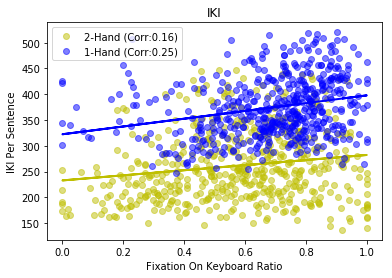

In [48]:

drawGraph2([calculateFixIKI('1'),calculateFixIKI('2')], 'IKI','Fixation On Keyboard Ratio','IKI Per Sentence','IKI')
#去掉outlier IKI（实验里有个停顿，读readme找到它，标记出来）

[4.1367604638371036, 1.1278617571654026]
outlier rejected:
[1.6389371740749938, 1.086123179146435, 6.666666666666667, 6.540447504302926, 6.8399452804377567, 0.89277323559815802, 7.0113935144609991, 1.6036461850101282, 1.1000550027501375, 6.5209052550824707, 6.6072018500165184, 1.8463514489845068, 6.5984072810011369, 6.5685759327377822, 6.4063453325198285, 6.7825349724459514, 7.5366917889726306, 7.4016361511492015]
[2.7223578021024566, 0.494797611472657]
outlier rejected:
[3.7445392136467652, 1.5761821366024518, 3.8391594261466966, 4.1605991262741835, 1.5514900769280497, 3.761755485893417, 1.5846383296047728, 3.8643194504079004, 3.7819799777530587, 3.8042099923915798, 3.7555479685899629, 1.474805407619828, 1.532734836873221, 1.6722408026755853, 3.7620503174229953, 3.9791857973676152, 1.7150820023582378, 4.5184975995481507, 3.9790197142340387, 4.588263704419222]


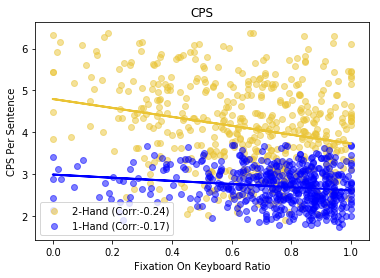

In [43]:
drawGraph2([calculateFixIKI('1'),calculateFixIKI('2')], 'CPS','Fixation On Keyboard Ratio','CPS Per Sentence','CPS')

[264.12383186922165, 94.504976756879799]
[1.3624031007751938, 1.7505428948349284]
outlier rejected:
[610.15151515151513, 920.70588235294122, 1120.1052631578948, 623.57894736842104, 489.05555555555554, 909.0454545454545, 454.79411764705884, 525.05555555555554, 541.60869565217388, 475.5, 464.0, 490.27272727272725, 494.77777777777777, 479.93333333333334, 453.33333333333331, 297.80645161290323, 191.1904761904762, 223.78787878787878, 241.59259259259258, 247.5, 272.51724137931035, 320.875, 296.06060606060606, 240.59375, 283.4871794871795, 293.60465116279067, 269.29411764705884, 399.06976744186045, 337.53571428571428, 395.6764705882353, 345.87878787878788, 372.58064516129031, 285.31578947368422, 381.53703703703701, 326.90625, 384.65789473684208, 271.25925925925924, 332.52173913043481, 445.07142857142856, 172.375, 163.0, 168.57692307692307, 187.62068965517241]
[1, 2, 0, 1, 2, 0, 1, 0, 3, 0, 1, 3, 2, 3, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,

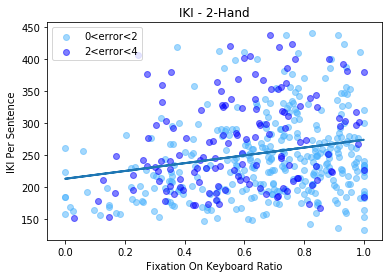

In [24]:
info = calculateFixIKI('1')
drawGraph3(info[0], info[1], info[3], 'IKI - 2-Hand','Fixation On Keyboard Ratio','IKI Per Sentence')



[2.7223578021024566, 0.494797611472657]
[1.0057692307692307, 1.2223737093078779]
outlier rejected:
[3.7445392136467652, 1.5761821366024518, 3.8391594261466966, 4.1605991262741835, 1.5514900769280497, 3.761755485893417, 1.5846383296047728, 3.8643194504079004, 3.7819799777530587, 3.8042099923915798, 3.7555479685899629, 1.474805407619828, 1.532734836873221, 1.6722408026755853, 3.7620503174229953, 3.9791857973676152, 1.7150820023582378, 4.5184975995481507, 3.9790197142340387, 4.588263704419222, 3.3207374327264403, 2.698263725950258, 2.3368685960812514, 2.9843619434164976, 2.4875621890547261, 2.2282570851612005, 2.0210526315789474, 3.2556974705735038, 2.254791431792559, 2.6440453894458522, 2.8700739595981899, 2.4946543121881684, 2.767208578346593, 2.4410953088516236, 2.0903274846392601, 2.6689959722424419, 2.6666666666666665, 3.25, 3.3072023517883391, 3.0626358427188305, 3.0621172353455819, 3.4825870646766166, 3.7014188772362737, 3.4882098507046182, 3.3680342927127982]
[0, 3, 0, 1, 2, 1, 1,

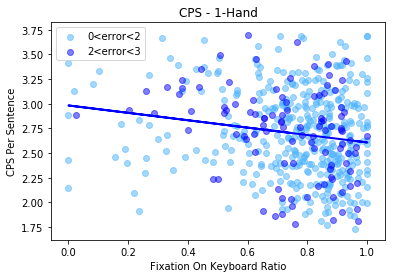

In [49]:
info = calculateFixIKI('2')
drawGraph3(info[0], info[2], info[3], 'CPS - 1-Hand','Fixation On Keyboard Ratio','CPS Per Sentence')